In [ ]:
# Run this cell to mount your drive to this notebook in order to read the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [ ]:
# Put the folder path where the datasets are located
PATH = "/content/drive/MyDrive/CS445_text_classif/"

In [ ]:
# Read the train and test set with read_csv() method of pandas
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

### Preprocess Dataset

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train.head()

,Unnamed: 0,text,label
0,0,I came here and left a review before but last ...,1
1,1,Had a very nice first visit here. The owner Te...,4
2,2,This is a gorgeous and very clean hotel. We h...,4
3,3,The gym is dirty. I have given up. Locker ro...,1
4,4,"The food here is delicious, fast, and consiste...",5


In [ ]:
# Define a function to perform preprocessing. This function can perform things like lowercasing, stemming, removing stopwords, etc.
stemmer = PorterStemmer() 
stop_words = set(stopwords.words('english'))

def preprocess(text: str):
  text = text.lower()

  tokens = text.split()

  filtered_sentence = []
  for w in tokens:
    if w not in stop_words:
      filtered_sentence.append(w)

  stemmed_tokens = [stemmer.stem(word) for word in filtered_sentence]
  text = ' '.join(stemmed_tokens)
  return text

In [ ]:
# Apply your preprocessing function to your text fields.

train.text = train.text.apply(preprocess)
test.text = test.text.apply(preprocess)


train.shape, test.shape

((18000, 3), (2000, 3))

In [ ]:
train.head(3)

,Unnamed: 0,text,label
0,0,came left review last time get food poisoning....,1
1,1,"nice first visit here. owner ted, friendli sta...",4
2,2,gorgeou clean hotel. room west wing. first cho...,4


In [ ]:
# Create your binary and multiclass datasets

# For binary dataset, get rid of the class 3 in the dataset and map class 1 and 2 to 0, and class 4 and 5 to 1
binary_train = train[train['label'] != 3]
binary_train['label'] = binary_train['label'].map({1:0, 2:0,4:1, 5:1})

binary_test = test[test['label'] != 3]
binary_test['label'] = binary_test['label'].map({1:0, 2:0,4:1, 5:1})


# For multiclass dataset, make sure your classes starts from 0 and goes until 4. (5->4, 4->3, 3->2, 2->1, 1->0)
multiclass_train = train
multiclass_test = test
multiclass_train['label'] = train['label'].map({1:0, 2:1,3:2,4:3, 5:4})
multiclass_test['label'] = test['label'].map({1:0, 2:1,3:2,4:3, 5:4})

In [ ]:
binary_x = binary_train['text']
binary_y = binary_train['label']



In [ ]:
multiclass_x = multiclass_train['text']
multiclass_y = multiclass_train['label']

# Models

## Non-Neural Models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

### Naive Bayes

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

# Create a class for converting sparse matrix output of TfidfVectorizer to dense matrix for feeding into GaussianNB
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) TfidfVectorizer 2) DenseTransformer 3) Naive Bayes classifier.

pipeline = Pipeline([
     ('vectorizer',TfidfVectorizer()), 
     ('to_dense', DenseTransformer()), 
     ('classifier', GaussianNB())
])


# Set the hyperparameter space that will be scanned with GridSearchCV.
parameters_NB = [{
    'vectorizer__min_df': (100, 500, 1000),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1,3),)   
}]



### Binary

{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 1)}: 0.005932169613107815
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}: 0.004739687599397128
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 3)}: 0.004663719439615708
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 1)}: 0.008602738344797023
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 2)}: 0.007416214468649685
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 3)}: 0.007416214468649685
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 1)}: 0.005758407446393538
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 2)}: 0.005758407446393538
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 3)}: 0.005758407446393538

BEST PARAMS: {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}

Accuracy: 0.8618957940991839
F1:0.8626716604244695



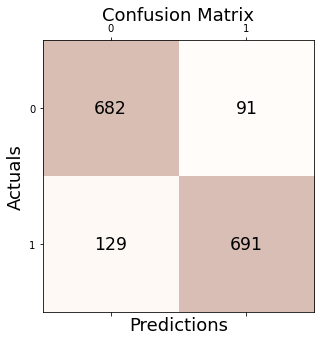

CPU times: user 1min 51s, sys: 4.23 s, total: 1min 55s
Wall time: 1min 55s


In [ ]:
%%time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.

grid_search_NB = GridSearchCV(pipeline, parameters_NB, cv=5)
NB_model_binary = grid_search_NB.fit(binary_x, binary_y)




# Report the standart deviation of split scores for each hyperparameter group.
params_binaryNB = NB_model_binary.cv_results_.get('params')
p = 0
for param in params_binaryNB:
  print(str(param) + ': ' + str(NB_model_binary.cv_results_.get('std_test_score')[p]) )
  p+=1


# Show the best parameter set for given dataset and hyperparameter space.
best_params_binaryNB = NB_model_binary.best_params_
print('\n' +'BEST PARAMS: ' + str(NB_model_binary.best_params_) + '\n')

# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your Pipeline object with the best parameter set.

pipeline_optimal_binaryNB = Pipeline([
     ('vectorizer',TfidfVectorizer(ngram_range= best_params_binaryNB.get('vectorizer__ngram_range'), min_df = best_params_binaryNB.get('vectorizer__min_df'))), 
     ('to_dense', DenseTransformer()), 
     ('classifier', GaussianNB())
])


# Fit your pipeline on training set.
optimalmodel_binaryNB = pipeline_optimal_binaryNB.fit(binary_x, binary_y)


# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

y_pred = optimalmodel_binaryNB.predict(binary_test['text'])
accuracy = optimalmodel_binaryNB.score(binary_test['text'], binary_test['label']) 

print('Accuracy: ' + str(accuracy) + '\n' 'F1:' + str(f1_score(binary_test['label'], y_pred)) + '\n')

conf_matrix = confusion_matrix(y_true=binary_test['label'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


### Multi

{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 1)}: 0.010306117085630067
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}: 0.012163241527012616
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 3)}: 0.012268347308379082
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 1)}: 0.007694795419191466
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 2)}: 0.00806493706587616
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 3)}: 0.00806493706587616
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 1)}: 0.003753187945345464
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 2)}: 0.003753187945345464
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 3)}: 0.003753187945345464

BEST PARAMS: {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 3)}

Accuracy: 0.4855
F1:0.47346364249104794



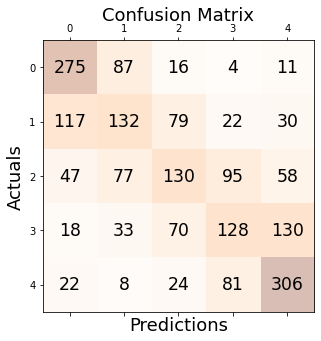

CPU times: user 2min 32s, sys: 3.09 s, total: 2min 35s
Wall time: 2min 38s


In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.

NB_model_multiclass = grid_search_NB.fit(multiclass_x, multiclass_y)


# Report the standart deviation of split scores for each hyperparameter group.
params_multiclassNB = NB_model_multiclass.cv_results_.get('params')
p = 0
for param in params_multiclassNB:
  print(str(param) + ': ' + str(NB_model_multiclass.cv_results_.get('std_test_score')[p]) )
  p+=1



# Show the best parameter set for given dataset and hyperparameter space.
best_params_multiclassNB = NB_model_multiclass.best_params_
print('\n' +'BEST PARAMS: ' + str(best_params_multiclassNB) + '\n')


# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your pipeline object with the best parameter set.

pipeline_optimal_multiclassNB = Pipeline([
     ('vectorizer',TfidfVectorizer(ngram_range= best_params_multiclassNB.get('vectorizer__ngram_range'), min_df = best_params_multiclassNB.get('vectorizer__min_df'))), 
     ('to_dense', DenseTransformer()), 
     ('classifier', GaussianNB())
])



# Fit your pipeline on training set.
optimalmodel_multiclassNB = pipeline_optimal_multiclassNB.fit(multiclass_x, multiclass_y)



# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

y_pred = optimalmodel_multiclassNB.predict(multiclass_test['text'])
accuracy = optimalmodel_multiclassNB.score(multiclass_test['text'], multiclass_test['label']) 

print('Accuracy: ' + str(accuracy) + '\n' 'F1:' + str(f1_score(multiclass_test['label'], y_pred,average='weighted')) + '\n')

conf_matrix = confusion_matrix(y_true=multiclass_test['label'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()




In [ ]:
NB_model_multiclass.cv_results_

{'mean_fit_time': array([1.12651982, 2.88128438, 4.73512378, 0.81527882, 2.70096679,
        4.86494465, 0.75300226, 2.47041264, 4.44692984]),
 'mean_score_time': array([0.39653802, 0.59579053, 0.7625607 , 0.18061476, 0.38767786,
        0.54368634, 0.1626298 , 0.33266311, 0.52955794]),
 'mean_test_score': array([0.45855556, 0.47133333, 0.47155556, 0.44466667, 0.44533333,
        0.44533333, 0.40966667, 0.40966667, 0.40966667]),
 'param_vectorizer__min_df': masked_array(data=[100, 100, 100, 500, 500, 500, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_vectorizer__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3), (1, 1), (1, 2), (1, 3), (1, 1),
                    (1, 2), (1, 3)],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [

### Logistic Regression

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) Word weightning 2) Logistic Regression classifier.


pipeline_LR = Pipeline([
     ('vectorizer',TfidfVectorizer()), 
     ('classifier', LogisticRegression(random_state=22))
])


#Set the hyperparameter space that will be scanned.
parameters_LR = [{
    'vectorizer__min_df': (100, 500, 1000),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1,3),)   
}]



#### Binary

{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 1)}: 0.003129369581835232
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}: 0.004122093603583579
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 3)}: 0.004131671050813826
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 1)}: 0.006748651645060319
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 2)}: 0.006791235291311902
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 3)}: 0.006791235291311902
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 1)}: 0.0045675768416623755
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 2)}: 0.0045675768416623755
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 3)}: 0.0045675768416623755

BEST PARAMS: {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}

Accuracy: 0.9033270558694287
F1:0.904228855721393



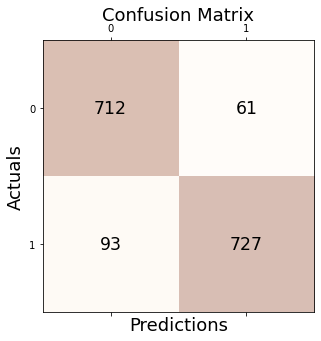

CPU times: user 1min 52s, sys: 1.83 s, total: 1min 53s
Wall time: 1min 56s


In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.


grid_search_LR = GridSearchCV(pipeline_LR, parameters_NB, cv=5)
LR_model_binary = grid_search_LR.fit(binary_x, binary_y)



        
# Report the standart deviation of split scores for each hyperparameter group.

params_binaryLR = LR_model_binary.cv_results_.get('params')
p = 0
for param in params_binaryLR:
  print(str(param) + ': ' + str(LR_model_binary.cv_results_.get('std_test_score')[p]) )
  p+=1



# Show the best parameter set for given dataset and hyperparameter space.

best_params_binaryLR = LR_model_binary.best_params_
print('\n' +'BEST PARAMS: ' + str(LR_model_binary.best_params_) + '\n')





# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
#Create your pipeline object with the best parameter set.
pipeline_optimal_binaryLR = Pipeline([
     ('vectorizer',TfidfVectorizer(ngram_range= best_params_binaryLR.get('vectorizer__ngram_range'), min_df = best_params_binaryNB.get('vectorizer__min_df'))), 
     ('classifier', LogisticRegression())
])



# Fit your pipeline on training set.

optimalmodel_binaryLR = pipeline_optimal_binaryLR.fit(binary_x, binary_y)


# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

y_pred = optimalmodel_binaryLR.predict(binary_test['text'])
accuracy = optimalmodel_binaryLR.score(binary_test['text'], binary_test['label']) 

print('Accuracy: ' + str(accuracy) + '\n' 'F1:' + str(f1_score(binary_test['label'], y_pred)) + '\n')

conf_matrix = confusion_matrix(y_true=binary_test['label'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#### Multiclass

{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 1)}: 0.010871868784353396
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}: 0.011266962520770382
{'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 3)}: 0.011263400797754834
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 1)}: 0.009275282432224427
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 2)}: 0.009640769909319712
{'vectorizer__min_df': 500, 'vectorizer__ngram_range': (1, 3)}: 0.009640769909319712
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 1)}: 0.008019266922562739
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 2)}: 0.008019266922562739
{'vectorizer__min_df': 1000, 'vectorizer__ngram_range': (1, 3)}: 0.008019266922562739

BEST PARAMS: {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}

Accuracy: 0.5505
F1:0.5502070287254195



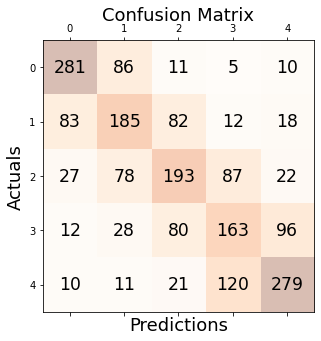

CPU times: user 3min 27s, sys: 3.19 s, total: 3min 30s
Wall time: 3min 32s


In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.


grid_search_LR = GridSearchCV(pipeline_LR, parameters_NB, cv=5)
LR_model_multiclass = grid_search_LR.fit(multiclass_x, multiclass_y)



        
# Report the standart deviation of split scores for each hyperparameter group.

params_multiclassLR = LR_model_multiclass.cv_results_.get('params')
p = 0
for param in params_multiclassLR:
  print(str(param) + ': ' + str(LR_model_multiclass.cv_results_.get('std_test_score')[p]) )
  p+=1



# Show the best parameter set for given dataset and hyperparameter space.

best_params_multiclassLR = LR_model_multiclass.best_params_
print('\n' +'BEST PARAMS: ' + str(LR_model_multiclass.best_params_) + '\n')





# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
#Create your pipeline object with the best parameter set.
pipeline_optimal_multiclassLR = Pipeline([
     ('vectorizer',TfidfVectorizer(ngram_range= best_params_multiclassLR.get('vectorizer__ngram_range'), min_df = best_params_multiclassNB.get('vectorizer__min_df'))), 
     ('classifier', LogisticRegression())
])



# Fit your pipeline on training set.

optimalmodel_multiclassLR = pipeline_optimal_multiclassLR.fit(multiclass_x, multiclass_y)


# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

y_pred = optimalmodel_multiclassLR.predict(multiclass_test['text'])
accuracy = optimalmodel_multiclassLR.score(multiclass_test['text'], multiclass_test['label']) 

print('Accuracy: ' + str(accuracy) + '\n' 'F1:' + str(f1_score(multiclass_test['label'], y_pred,average='weighted')) + '\n')

conf_matrix = confusion_matrix(y_true=multiclass_test['label'], y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Neural Models

### Convolutional Neural Network (CNN)

In [ ]:
import pandas as pd
import numpy as np
import nltk,re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import array,asarray,zeros

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import Dense,Flatten,Embedding,Input,Dropout
from keras.callbacks import ModelCheckpoint

from gensim.models import Word2Vec
import gensim.downloader as api

from collections import Counter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Create a validation set from train set
# Please use random_state of 22 and test_size of 0.1




Xb_train, Xb_val, yb_train, yb_val = train_test_split(binary_x, binary_y, test_size=0.1, random_state=22)

Xm_train, Xm_val, ym_train, ym_val = train_test_split(multiclass_x, multiclass_y, test_size=0.1, random_state=22)






In [ ]:
# Create your own word embeddings from scratch and load a pretrained word embeddings




# You can check https://radimrehurek.com/gensim/models/word2vec.html for training a word embeddings from scratch









# You can check https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html and https://github.com/RaRe-Technologies/gensim-data for loading pretrained word embeddings. 








Xb_train



17174    thoroughli dissatisfi today' experi judg beans...
6381     price intimid worth it! owner awesom human. ba...
14980    far wors starbuck entir city. terribl custom s...
4542     i'll start say i'm coffe buff, certainli enjoy...
11771    absolut favourit place greasi chines food. bes...
                               ...                        
6824     smoke allowed. there, said it. good equipment,...
10668    updat review 1 star initi reach say would cont...
16379    i'v alway heard great thing groothi tri it. gi...
7834     made reserv week ahead time larg group (12 peo...
13918    loyal custom years, recent experience! got oil...
Name: text, Length: 12966, dtype: object

In [ ]:
def load_doc(path):
	file = open(path, 'r')
	text = file.read()
	file.close()
	return text

vocab_x = load_doc('/content/drive/MyDrive/CS445_text_classif/vocab.txt')
vocab_x = vocab_x.split()
len(vocab_x)

15001

In [159]:
# Prepare your dataset for CNN classifier
import string 
def text_to_clean_list(text ,vocab):
  token_list = list()
 
  for review in text:
    tokens_punc = review.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens_punc]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [word for word in tokens if word in vocab]
    text = ' '.join(tokens)
    token_list.append(text)
    

	
  return token_list

def form_listofwords(text):
  token_list = list()
 
  for review in text:
    tokens_punc = review.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens_punc]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word) > 1]
    token_list.append(tokens)
    

	
  return token_list

def formatter(tokenizer, doc, y_s,max_length):
  tokenizer.fit_on_texts(doc)
  encoded_doc = tokenizer.texts_to_sequences(doc)
  X = pad_sequences(encoded_doc, maxlen=max_length, padding='post')
  y = y_s

  return X,y

token_list = form_listofwords(binary_x)
vocab_x = Counter()
for r in token_list:
  vocab_x.update(r)
vocab_x = {k: v for k, v in vocab_x.items() if v > 3}

vocab_x = Counter(vocab_x)


with open('/content/drive/MyDrive/CS445_text_classif/vocab.txt', 'w') as filehandle:
    for word in vocab_x:
        filehandle.write('%s\n' % word)


def load_doc(path):
	file = open(path, 'r')
	text = file.read()
	file.close()
	return text

vocab_x = load_doc('/content/drive/MyDrive/CS445_text_classif/vocab.txt')
vocab_x = vocab_x.split()
print(len(vocab_x))

train_doc = text_to_clean_list(Xb_train, vocab_x)
max_length = max([len(s.split()) for s in train_doc])
test_doc = text_to_clean_list(binary_test['text'].squeeze(), vocab_x)
val_doc = text_to_clean_list(Xb_val, vocab_x)


tokenizer = Tokenizer()
Xtrain, ytrain = formatter(tokenizer, train_doc, yb_train, max_length)
Xtest, ytest = formatter(tokenizer, test_doc, binary_test['label'].squeeze(),max_length)
Xval, yval = formatter(tokenizer, val_doc, yb_val,max_length)




9796


####Binary

In [ ]:
 
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
 print(vocab_size)
# define model
model = Sequential()
model.add(Embedding(vocab_size, 20, input_length=max_length))
model.add(Conv1D(filters=150, kernel_size=8, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

9797
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 471, 20)           195940    
                                                                 
 conv1d_17 (Conv1D)          (None, 464, 150)          24150     
                                                                 
 dropout_7 (Dropout)         (None, 464, 150)          0         
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 232, 150)         0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 34800)             0         
                                                                 
 dense_32 (Dense)            (None, 6)                 208806    
                                                

In [156]:
# Train models and Evaluate them for both binary and multi-class


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, validation_data=(Xval, yval),  epochs=3, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))





Epoch 1/3
406/406 - 74s - loss: 0.3137 - accuracy: 0.8670 - val_loss: 0.7141 - val_accuracy: 0.6808 - 74s/epoch - 182ms/step
Epoch 2/3
406/406 - 55s - loss: 0.2379 - accuracy: 0.9054 - val_loss: 0.7360 - val_accuracy: 0.6613 - 55s/epoch - 136ms/step
Epoch 3/3
406/406 - 49s - loss: 0.1956 - accuracy: 0.9248 - val_loss: 0.8017 - val_accuracy: 0.6676 - 49s/epoch - 121ms/step
Test Accuracy: 64.846200


####Multiclass

In [157]:
train_doc = text_to_clean_list(Xm_train, vocab_x)
max_length = max([len(s.split()) for s in train_doc])
test_doc = text_to_clean_list(multiclass_test['text'].squeeze(), vocab_x)
val_doc = text_to_clean_list(Xm_val, vocab_x)


tokenizer = Tokenizer()
Xtrain, ytrain = formatter(tokenizer, train_doc, ym_train, max_length)
Xtest, ytest = formatter(tokenizer, test_doc, binary_test['label'].squeeze(),max_length)
Xval, yval = formatter(tokenizer, val_doc, ym_val,max_length)

In [158]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, validation_data=(Xval, yval),  epochs=3, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/3


KeyboardInterrupt: ignored

In [ ]:
def load_embedding(filename):
	file = open(filename,'r')
	lines = file.readlines()
	file.close()
	embedding = dict()
	for line in lines:
		parts = line.split()
		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
	return embedding
 
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	vocab_size = len(vocab) + 1
	weight_matrix = zeros((vocab_size, 100))
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix
raw_embedding = load_embedding('/content/drive/MyDrive/CS445_text_classif/glove.6B.100d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)



In [ ]:
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [ ]:

 
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 471, 100)          979700    
                                                                 
 conv1d_19 (Conv1D)          (None, 467, 128)          64128     
                                                                 
 dropout_9 (Dropout)         (None, 467, 128)          0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 233, 128)         0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 29824)             0         
                                                                 
 dense_36 (Dense)            (None, 1)                 29825     
                                                     

In [ ]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=3, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/3
406/406 - 50s - loss: 0.6221 - accuracy: 0.6512 - val_loss: 0.5716 - val_accuracy: 0.7113 - 50s/epoch - 123ms/step
Epoch 2/3
406/406 - 49s - loss: 0.4936 - accuracy: 0.7603 - val_loss: 0.6398 - val_accuracy: 0.6759 - 49s/epoch - 121ms/step
Epoch 3/3
406/406 - 50s - loss: 0.4040 - accuracy: 0.8151 - val_loss: 0.6264 - val_accuracy: 0.6967 - 50s/epoch - 123ms/step
Test Accuracy: 65.222847


In [160]:
filter = [32,64,128]
kernel_size = [4,8,12]
for f in filter:
  for k in kernel_size:
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
    model.add(Dropout(rate = 0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=3, verbose=2)
    loss, acc = model.evaluate(Xtest, ytest, verbose=0)
    print('Test Accuracy: %f' % (acc*100))

Epoch 1/3
406/406 - 18s - loss: 0.6467 - accuracy: 0.6204 - val_loss: 0.6054 - val_accuracy: 0.6773 - 18s/epoch - 45ms/step
Epoch 2/3
406/406 - 18s - loss: 0.5469 - accuracy: 0.7172 - val_loss: 0.5877 - val_accuracy: 0.6995 - 18s/epoch - 45ms/step
Epoch 3/3
406/406 - 17s - loss: 0.4883 - accuracy: 0.7646 - val_loss: 0.5930 - val_accuracy: 0.7058 - 17s/epoch - 43ms/step
Test Accuracy: 66.415566
Epoch 1/3
406/406 - 29s - loss: 0.6472 - accuracy: 0.6161 - val_loss: 0.5888 - val_accuracy: 0.7071 - 29s/epoch - 71ms/step
Epoch 2/3
406/406 - 28s - loss: 0.5463 - accuracy: 0.7154 - val_loss: 0.5929 - val_accuracy: 0.7078 - 28s/epoch - 70ms/step
Epoch 3/3
406/406 - 30s - loss: 0.4841 - accuracy: 0.7656 - val_loss: 0.6440 - val_accuracy: 0.6766 - 30s/epoch - 74ms/step
Test Accuracy: 64.218456
Epoch 1/3
406/406 - 40s - loss: 0.6503 - accuracy: 0.6169 - val_loss: 0.5889 - val_accuracy: 0.6822 - 40s/epoch - 98ms/step
Epoch 2/3
406/406 - 39s - loss: 0.5482 - accuracy: 0.7170 - val_loss: 0.5776 - val

In [161]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=10, verbose=2)
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/10
406/406 - 18s - loss: 0.6400 - accuracy: 0.6296 - val_loss: 0.5809 - val_accuracy: 0.6947 - 18s/epoch - 44ms/step
Epoch 2/10
406/406 - 17s - loss: 0.5398 - accuracy: 0.7291 - val_loss: 0.5660 - val_accuracy: 0.7183 - 17s/epoch - 42ms/step
Epoch 3/10
406/406 - 17s - loss: 0.4844 - accuracy: 0.7671 - val_loss: 0.5804 - val_accuracy: 0.7238 - 17s/epoch - 42ms/step
Epoch 4/10
406/406 - 17s - loss: 0.4365 - accuracy: 0.7965 - val_loss: 0.6213 - val_accuracy: 0.7113 - 17s/epoch - 42ms/step
Epoch 5/10
406/406 - 18s - loss: 0.4018 - accuracy: 0.8151 - val_loss: 0.6706 - val_accuracy: 0.6662 - 18s/epoch - 44ms/step
Epoch 6/10
406/406 - 17s - loss: 0.3756 - accuracy: 0.8332 - val_loss: 0.6637 - val_accuracy: 0.6905 - 17s/epoch - 42ms/step
Epoch 7/10
406/406 - 17s - loss: 0.3502 - accuracy: 0.8466 - val_loss: 0.6758 - val_accuracy: 0.6974 - 17s/epoch - 42ms/step
Epoch 8/10
406/406 - 17s - loss: 0.3162 - accuracy: 0.8611 - val_loss: 0.7155 - val_accuracy: 0.6669 - 17s/epoch - 42ms/step


# My Report

##Preprocessing
In this phase, the processes that were applied to the dataset(both the test and the training datasets are as follows:
- Lowercasing
- Stemming
- Stop word removal

Then, the test and training datasets are formatted into two formats namely, multiclass and binary.
##Model-training
Two machine learning techniques namely, Naive Bayes Classifier and Logistic Regression Classifier were used and out of the two Logistic regression scored better in both accuracy and F1 measurements.
###Machine learning

For both models the hyperparameter space that was explored was:
parameters_NB = [{
    'vectorizer__min_df': (100, 500, 1000),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1,3),)   
}]
as instructed in the document. 
For both the binary and the multiclass classification, logistic regression scored better than Naive Bayes.

LR -->%90 - % 55
NB -->%86 - % 48

For obvious reasons of binary classification being an easier task to be done, the deficit of accuracy from binary to multiclass classification in both models is expected. However, when the respective confusion matrices above are further evaluated it can be observed that most of the misclassifications happen between classes that are closer to each other rather than further which is an encouraging sign.

###Deep learning

In this part of the code the source that was most utilized was: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

The results gotten from neural-based models are surprisingly low in spite of attempts to improve it via hyperparameter tuning, this, i believe is related to an error that is done by me while preparing the data for the embeddings. However, this error is still undetected.

The best accuracy(%68) was obtained using the embedding pre-trained on wikipedia data. Therefore, structural optimization was only done on that particular network.

Looking at the hyperparameter tuning results, the simpler the architecture is (min # of filters) the better the model performs. This comes down to the dataset being a relatively small dataset with at most 20000 reviews. The lack of multiplicity of data causes the models to be easily overfit due to lacking variety in the dataset.
The best scoring parameters (filters = 32 , kernel = 4)

However, as previous mentioned, the overfitting whose reason went undetected caused challenges to the analysis which might cause me to have deceiving results as a result.

